## 1. Import necessary modules

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import random
from tensorflow.keras import layers, Model
import time
import re

from IPython import display

## 2. Data

In [ ]:
import gdown
!gdown "https://drive.google.com/uc?id=1Ef5-NAV1MAQ73vxN9BHyHAXi0UK6TDSy"

Downloading...
From: https://drive.google.com/uc?id=1Ef5-NAV1MAQ73vxN9BHyHAXi0UK6TDSy
To: /content/Hackathon_2_Dataset.zip
100% 764k/764k [00:00<00:00, 21.6MB/s]


In [ ]:
import zipfile
import os

zip_file_path = '/content/Hackathon_2_Dataset.zip'
extracted_dir_path = '/content/'

os.makedirs(extracted_dir_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [ ]:
data_dir = "/content/Hackathon_2_Dataset"

num_labels = []
for root, dirs, files in os.walk(data_dir+"/img",topdown=True):
    for file_name in sorted(files):
        new_file_name = re.sub(r'\.', '_', file_name)
        try :
            num = int(new_file_name.split('_')[-2])
            num_labels.append(num-64)
        except :
            pass
np.unique(np.array(num_labels),return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26]),
 array([66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66,
        66, 66, 66, 66, 66, 66, 66, 66, 66]))

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,image_size=(36,36),batch_size=26, labels=num_labels)

Found 1716 files belonging to 26 classes.


### 2.1 Visualizing an image

(36, 36, 3)
tf.Tensor(22, shape=(), dtype=int32)


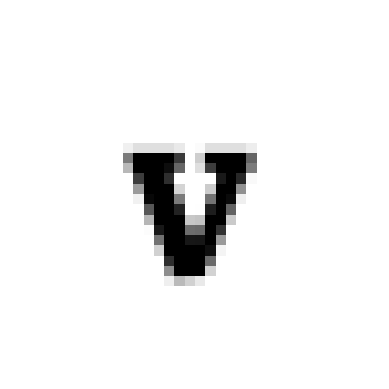

In [ ]:
for images, labels in train_dataset.take(1):
  for i in range(1):
    image = images[i]
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
    plt.axis("off")
    print(images[i].shape)
    print(labels[i])

### 2.2 Data augmentation

In [ ]:
# augmentation_layer1 = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
augmentation_layer1 = tf.keras.layers.RandomRotation(factor=0.005)
augmentation_layer2 = tf.keras.layers.RandomRotation(factor=0.010)
augmentation_layer3 = tf.keras.layers.RandomRotation(factor=0.015)
augmented_ds1 = train_dataset.map(lambda x, y: (augmentation_layer1(x), y))
augmented_ds2 = train_dataset.map(lambda x, y: (augmentation_layer2(x), y))
augmented_ds3 = train_dataset.map(lambda x, y: (augmentation_layer3(x), y))
# augmented_ds3 = augmented_ds1.map(lambda x, y: (augmentation_layer2(x), y))

train_dataset = train_dataset.concatenate(augmented_ds1).concatenate(augmented_ds2).concatenate(augmented_ds3)

### 2.3 Normalizing the data to range [-1,1]

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))

### 3. Model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 26

In [ ]:
def generate_ohv_label(label):
    return tf.one_hot(label, 26)

In [ ]:
def make_generator_model():

    label = layers.Input(shape=(1,),dtype = tf.int32)
    noise = layers.Input(shape=(1,))

    nD = layers.Dense(100)(noise)
    lD = generate_ohv_label(label)

    merge = layers.Concatenate()([nD,lD[:,0,:]])

    out = layers.Dense(1024)(merge)

    out = layers.BatchNormalization(momentum=0.8)(out)
    out = layers.Activation("relu")(out)

    out = layers.Dense(10368)(out)
    out = layers.BatchNormalization(momentum=0.8)(out)
    out = layers.Activation("relu")(out)

    out = layers.Reshape((9, 9, 128))(out)

    out = layers.UpSampling2D((2, 2))(out)
    out = layers.Conv2D(64, (2, 2), padding='same',kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02))(out)
    out = layers.BatchNormalization(momentum=0.8)(out)
    out = layers.LeakyReLU(0.2)(out)

    out = layers.UpSampling2D((2, 2))(out)
    out = layers.Conv2D(3, (3, 3), padding='same', activation = "tanh",kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02))(out)

    model = Model([label, noise], out)
    return model

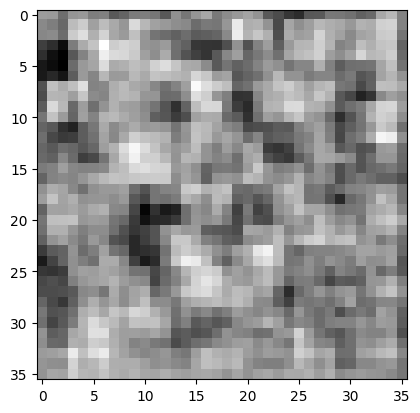

In [ ]:
generator = make_generator_model()

noise = tf.convert_to_tensor([np.random.normal(10)])
character = tf.convert_to_tensor([5])

generated_image = generator([character, noise],training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.one_hot (TFOpLambda)     (None, 1, 26)                0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 100)                  200       ['input_2[0][0]']             
                                                                                              

In [ ]:
def make_discriminator_model():
		in_shape=(36,36,3)
		n_classes=26

		in_image = layers.Input(shape=(36,36,3))
		label = layers.Input(shape=(1,),dtype=tf.int32)
		in_label = generate_ohv_label(label)

		li = layers.Dense(in_shape[0]*in_shape[1])(in_label)
		li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)

		merge = layers.Concatenate()([in_image, li])

		out = layers.Conv2D(64, (5, 5), strides=2, padding='same',
							kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02))(merge)
		out = layers.LeakyReLU(0.2)(out)

		out = layers.Conv2D(128, (5, 5), strides=2,
							kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.02))(out)
		out = layers.LeakyReLU(0.2)(out)

		out = layers.Flatten()(out)
		out = layers.Dense(256)(out)
		out = layers.LeakyReLU(0.2)(out)
		out = layers.Dropout(0.5)(out)
		out = layers.Dense(1)(out)

		model = Model([in_image, label], out)
		return model

In [ ]:
discriminator = make_discriminator_model()

decision = discriminator([generated_image,character])
print (decision)

tf.Tensor([[0.00064651]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.one_hot_1 (TFOpLambda)   (None, 1, 26)                0         ['input_4[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 1, 1296)              34992     ['tf.one_hot_1[0][0]']        
                                                                                                  
 input_3 (InputLayer)        [(None, 36, 36, 3)]          0         []                            
                                                                                            

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(9e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
seed_characters = np.random.randint(low=1, high=26, size=36)
seed_noise = np.random.normal(10,size=36)

In [ ]:
def generateImages(character, noise):
  predictions = generator([character,noise], training=False)
  fig = plt.figure(figsize=(8,8))
  for i in range(predictions.shape[0]):
      plt.subplot(6, 6, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.gca().set_title(chr(character[i]+64))
      plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(images,labels):
    noise = np.random.normal(10,size=BATCH_SIZE)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([labels, noise], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def trainModel(dataset, epochs):
  history = []
  for epoch in range(epochs):
      start = time.time()

      for image_batch,label_batch in dataset:
        g_loss, d_loss = train_step(image_batch,label_batch)
        history.append([g_loss, d_loss])

      display.clear_output(wait=True)
      generateImages(seed_characters,seed_noise)

      if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generateImages(seed_characters,seed_noise)
  return np.array(history)

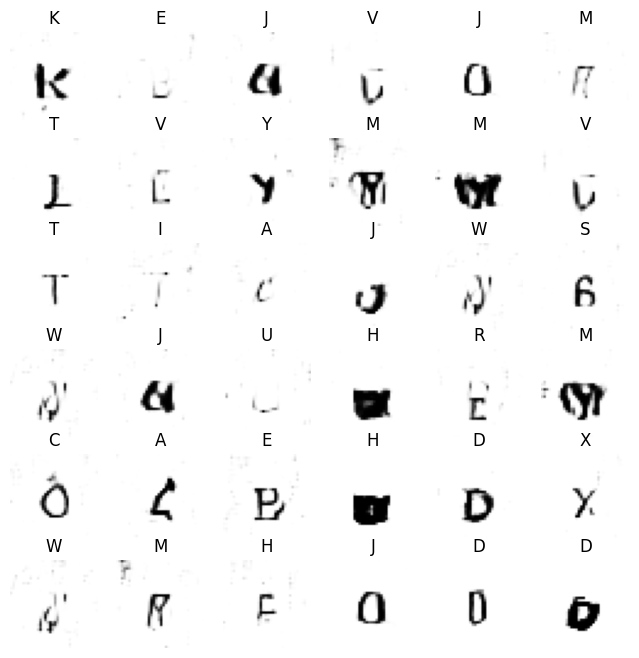

In [ ]:
training_history = trainModel(normalized_ds, 10)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

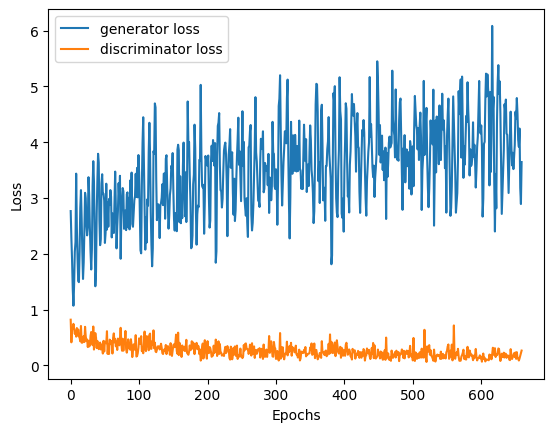

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(training_history[:,0], label='generator loss')
plt.plot(training_history[:,1], label='discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.savefig('./loss_curves.png')

In [ ]:
training_history[-1,0], training_history[-1,1]

(2.1369998, 0.41887334)

In [ ]:
def generateImage(character, noise):
    character = tf.convert_to_tensor([character])
    noise = tf.convert_to_tensor([noise])
    prediction = generator([character,noise], training=False)
    plt.imshow(prediction[0, :, :, :], cmap='gray')
    plt.axis('off')
    plt.show()
    out_image = prediction * 127.5 + 127.5
    return np.array(out_image[0])

### Testing

1. **Style variability:** Different noise vectors should generate different output styles.

[ 8.77211463  8.77211463  8.77211463  9.5491309   9.5491309   9.5491309
  9.99860721  9.99860721  9.99860721 10.33538048 10.33538048 10.33538048]


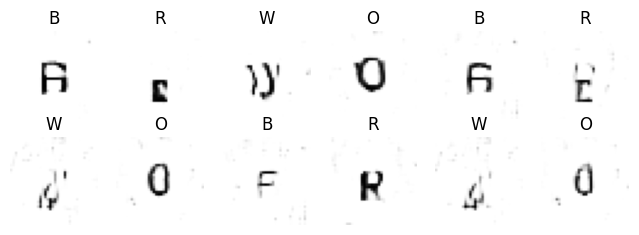

In [ ]:
Character = np.tile([np.random.randint(low=1, high=26, size=4)],3)[0]
Noise = np.array(sorted(np.tile([np.random.normal(10,size=4)],3)[0]))
print(Noise)
generateImages(Character, Noise)

2. **Character consistency:** The output image should correspond to the same input character irrespective of the noise vector.

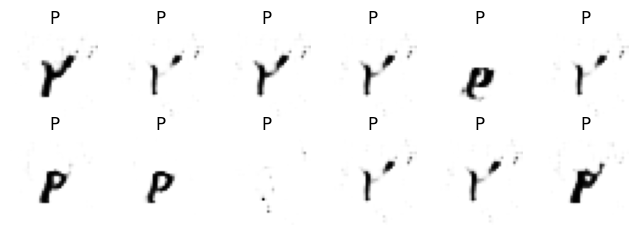

In [ ]:
Character = np.array([np.random.randint(low=1, high=26)]*12)
Noise = np.random.normal(10,size=12)
generateImages(Character, Noise)

3. **Style consistency:** all characters generated with the same noise vector should have the same style.

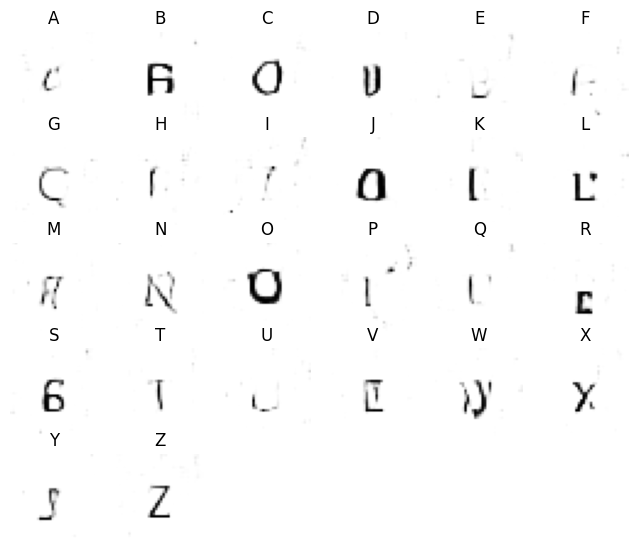

In [ ]:
Character = np.arange(1,27)
Noise = np.array([np.random.normal(10)]*26)
generateImages(Character, Noise)

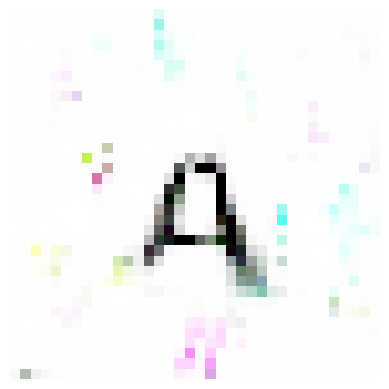

In [ ]:
# DO NOT CHANGE THIS BLOCK xxxxxxxxxxx
if __name__=="__main__":
    if False:
        trainModel()
    if True:
        character = 1 # this could be a number between 1-26 corresponding to A-Z
        noise = np.random.normal(10)
        Y = generateImage(character, noise)
        outfile = 'img.jpg'
        cv2.imwrite(outfile, Y)
# DO NOT CHANGE THIS BLOCK xxxxxxxxxxx